<a href="https://colab.research.google.com/github/kimdahyeon977/CS231N_17_KOR_SUB/blob/master/plantpathology_metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Metric Learning
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the packages

In [1]:
!pip install pytorch-metric-learning
!pip install -q faiss-gpu
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 23.2 MB/s 
     |████████████████████████████████| 85.5 MB 102 kB/s 
Cloning into 'pytorch_resnet_cifar10'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/Shareddrives/엘리스_AI프로젝트 /'

/content/drive/Shareddrives/엘리스_AI프로젝트 


## Import the packages

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from pytorch_resnet_cifar10 import resnet
from torchvision import datasets, transforms

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

## Create helper functions

In [5]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Create the dataset and load the trained model

In [9]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()
base_path='/content/drive/Shareddrives/엘리스_AI프로젝트 /'

0
[ 3813  3817  3826 ... 19893 19894 19895]
[   0    1    2 ... 4146 4149 4152]
1
[    0     1     2 ... 19893 19894 19895]
[3813 3817 3826 ... 8411 8417 8418]
2
[    0     1     2 ... 19893 19894 19895]
[ 7579  7592  7593 ... 12070 12072 12077]
3
[    0     1     2 ... 19893 19894 19895]
[11801 11810 11813 ... 15991 15999 16001]
4
[    0     1     2 ... 15991 15999 16001]
[15584 15647 15671 ... 19893 19894 19895]


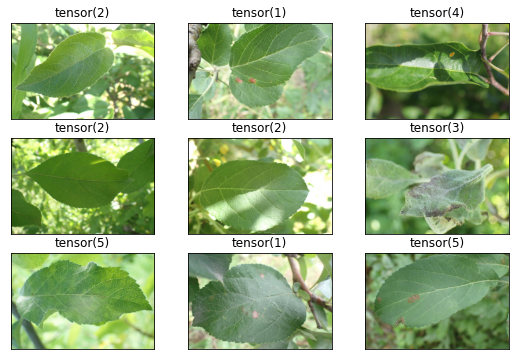

In [103]:
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
n_iter=0
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(df['image'], df['labels']):
            print(n_iter)
            n_iter+=1
            print(train_index)
            print(test_index)
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(self.data['labels'])
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.data = self.data.iloc[train_index] if mode == 'train' else self.data.iloc[test_index]
        self.img_names = list(self.data['image'])
        self.labels = list(self.data['labels'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        label = self.to_one_hot(label)
        label=np.argmax(label).reshape(-1,1)
        return img, torch.tensor(label[0][0])

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [104]:
train_data = df.iloc[train_index,]
test_data=df.iloc[test_index,]

In [109]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

In [14]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 21.5 MB/s 
     |████████████████████████████████| 419 kB 59.8 MB/s 
     |████████████████████████████████| 140 kB 70.5 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 1.1 MB 59.9 MB/s 
     |████████████████████████████████| 144 kB 46.9 MB/s 
     |████████████████████████████████| 271 kB 69.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


training dataset: 15917
test dataset: 3979
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: 339
image size: torch.Size([3, 224, 224])
<class 'torch.Tensor'>


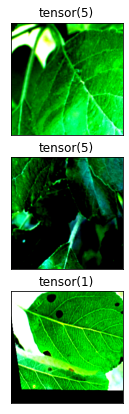

In [110]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    print(type(imgs))
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [111]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

dataset = dm.train_dataset
labels_to_indices = c_f.get_labels_to_indices(train_data['labels'])
model = torch.nn.DataParallel(resnet.resnet20())
checkpoint = torch.load("/content/pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th")
model.load_state_dict(checkpoint["state_dict"])
model.module.linear = c_f.Identity()
model.to(torch.device("cuda"))
print("done model loading")

done model loading


In [112]:
labels_to_indices

defaultdict(list,
            {'cider_apple_rust': array([    1,    10,    20, ..., 15848, 15857, 15868]),
             'frog_eye_leaf_spot': array([    2,     3,     5, ..., 15910, 15911, 15912]),
             'healthy': array([   12,    14,    17, ..., 15844, 15845, 15846]),
             'powdery_mildew': array([   11,    13,    15, ..., 15527, 15532, 15576]),
             'rust': array([    7,    30,    46, ..., 15721, 15739, 15746]),
             'scab': array([    0,     4,     6, ..., 15914, 15915, 15916])})

## Create the InferenceModel wrapper

In [113]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

# cars and frogs
classA, classB = labels_to_indices['cider_apple_rust'], labels_to_indices['healthy']

In [114]:
classB

array([   12,    14,    17, ..., 15844, 15845, 15846])

## Get nearest neighbors of a query

In [115]:
# create faiss index
inference_model.train_knn(dataset)

In [116]:
inference_model.save_knn_func("firstmodel.index")

query image


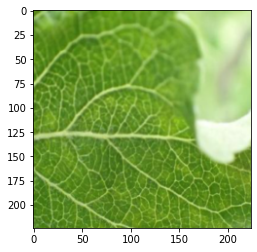

tensor([[0.0057, 0.0094, 0.0106, 0.0112, 0.0115, 0.0122, 0.0126, 0.0134, 0.0136,
         0.0139]], device='cuda:0')
nearest images


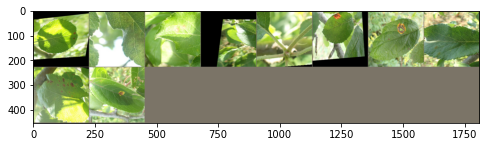

query image


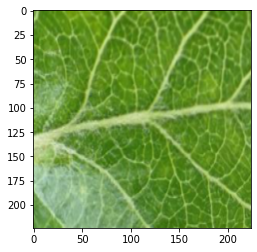

tensor([[0.0130, 0.0130, 0.0147, 0.0152, 0.0174, 0.0188, 0.0193, 0.0195, 0.0199,
         0.0207]], device='cuda:0')
nearest images


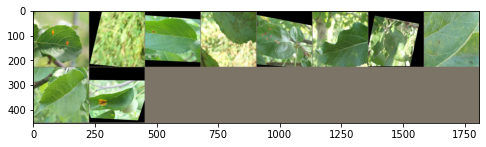

In [117]:
# get 10 nearest neighbors for a car image
for img_type in [classA, classB]:
    #img = dataset[img_type[0]][0].unsqueeze(0)
    img=dm.train_dataset[1][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    distances, indices = inference_model.get_nearest_neighbors(img, k=10)
    print(distances)
    nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

## Compare two images of the same class

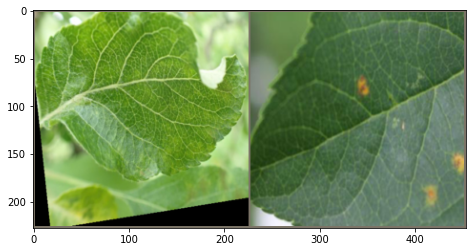

Same class


In [120]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

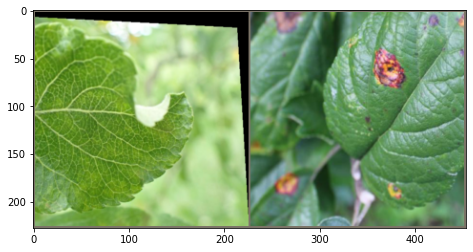

Same class


In [119]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

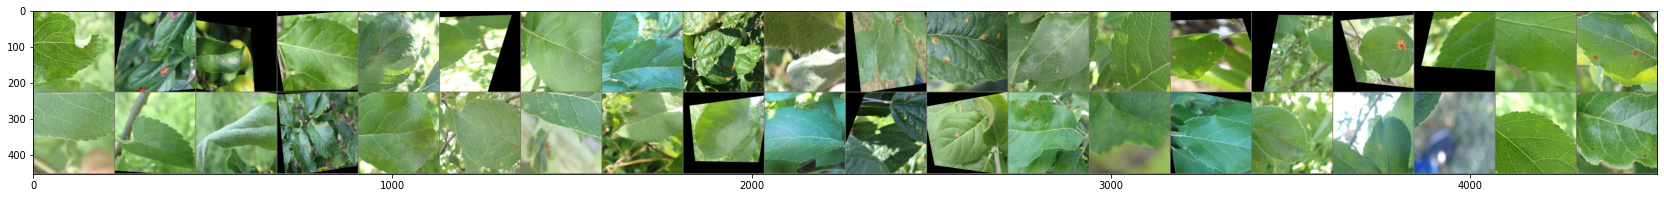

Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
accuracy = 1.0


In [121]:
# compare multiple pairs of images
x = torch.zeros(20, 3, 224, 224)
y = torch.zeros(20, 3, 224, 224)
for i in range(0, 20, 2):
    x[i] = dataset[classA[i]][0]
    x[i + 1] = dataset[classB[i]][0]
    y[i] = dataset[classA[i + 20]][0]
    y[i + 1] = dataset[classB[i + 20]][0]
imshow(torchvision.utils.make_grid(torch.cat((x, y), dim=0), nrow=20), figsize=(30, 3))
decision = inference_model.is_match(x, y)
for d in decision:
    print_decision(d)
print("accuracy = {}".format(np.sum(decision) / len(x)))

## Compare all pairs within a batch

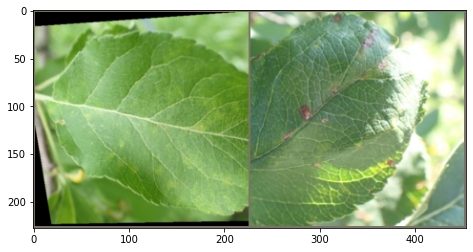

Same class


In [122]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0, 0]  # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3], x[4]), dim=0)))
print_decision(match_matrix[3, 4])  # does the 3rd image match the 4th image?

## Compare all pairs between queries and references

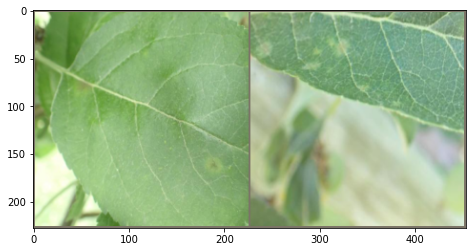

Same class


In [123]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6], y[6]), dim=0)))
print_decision(match_matrix[6, 6])  # does the 6th query match the 6th reference?

# Get results in tuple form